# DATA UNDERSTANDING AND PREPARATION

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import VarianceThreshold
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from collections import Counter
from collections import defaultdict
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from scikitplot.metrics import plot_roc
from sklearn.decomposition import PCA

# pip install scikit-plot

In [ ]:
#dataset import
df_train_csv = pd.read_csv("RavdessAudioOnlyFeatures_TRAIN.csv")
# df_test_csv = pd.read_csv("RavdessAudioOnlyFeatures_TEST.csv")

## FEATURE SELECTION

#### Feature selection with Variance Threshold

In [ ]:
## analisi della correlazione

df_train_continuo = df_train_csv.iloc[:,9:]

df_corr = df_train_continuo.corr()

# voglio togliere le variabili che hanno una correlazione maggiore di 0.97 in almeno 3 righe
# quindi ciclo per colonna e conto quanti valori maggiori di 0.97 ci sono e se sono almeno 3 aggiungo la variabile ad una lista che poi userò
# per rimuoverle dal dataset

high_corr = []
k = 0.95 #threshold
for var in df_train_continuo.columns:
    count=0
    for el in df_corr[var]:
        if el>k or el<-k :
            count+=1
    if count>=3:
        high_corr.append(var)
print(len(high_corr), high_corr)
df_train_continuo = df_train_continuo.copy(deep=True)
df_train_continuo = df_train_continuo.drop(columns=high_corr,axis=1)
df_train_continuo.shape

92 ['frame_count', 'std', 'min', 'max', 'q01', 'q05', 'q95', 'q99', 'lag1_std', 'lag1_min', 'lag1_max', 'lag1_q01', 'lag1_q05', 'lag1_q95', 'lag1_q99', 'zc_mean', 'zc_std', 'zc_kur', 'zc_skew', 'mfcc_std', 'mfcc_min', 'mfcc_q01', 'stft_mean', 'stft_q50', 'stft_skew', 'length_w1', 'std_w1', 'q01_w1', 'q99_w1', 'lag1_std_w1', 'lag1_q01_w1', 'lag1_q99_w1', 'zc_mean_w1', 'length_w2', 'std_w2', 'min_w2', 'max_w2', 'q01_w2', 'q05_w2', 'q95_w2', 'q99_w2', 'lag1_std_w2', 'lag1_min_w2', 'lag1_max_w2', 'lag1_q01_w2', 'lag1_q05_w2', 'lag1_q25_w2', 'lag1_q75_w2', 'lag1_q95_w2', 'lag1_q99_w2', 'zc_mean_w2', 'zc_std_w2', 'zc_skew_w2', 'stft_mean_w2', 'stft_q50_w2', 'stft_q75_w2', 'stft_skew_w2', 'length_w3', 'std_w3', 'min_w3', 'max_w3', 'q01_w3', 'q05_w3', 'q25_w3', 'q75_w3', 'q95_w3', 'q99_w3', 'lag1_std_w3', 'lag1_q01_w3', 'lag1_q05_w3', 'lag1_q25_w3', 'lag1_q95_w3', 'lag1_q99_w3', 'zc_std_w3', 'zc_skew_w3', 'mfcc_std_w3', 'stft_mean_w3', 'stft_q01_w3', 'stft_q50_w3', 'stft_q75_w3', 'stft_skew_w3

(1828, 333)

In [ ]:

df_train_continuo = df_train_continuo.loc[:, VarianceThreshold(0.15).fit(df_train_continuo).get_support()]
colonne_finali = (df_train_continuo.columns)
df_train_continuo.shape


(1828, 174)

In [ ]:
## rimozione stesse colonne anche dal test set
# df_test = df_test_csv.loc[:,colonne_finali]
# df_test.shape

#### Feature Selection with Decision Tree
This feature selection technique looks at importance weights to select the final features

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectFromModel
from scipy.stats import uniform, randint, loguniform
from sklearn.model_selection import RandomizedSearchCV, RepeatedStratifiedKFold

In [ ]:
emotion_train = df_train_csv['emotion']

In [ ]:
## PARAMETERS TUNING
'''param_grid = {
    "min_samples_split": loguniform(1e-2, 1e0),
    "min_samples_leaf": uniform(0.001, 0.2),
    "max_depth": randint(2, 200),
    "criterion": ["gini", "entropy"],
}
grid = RandomizedSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_distributions=param_grid,
    cv=RepeatedStratifiedKFold(random_state=42),
    n_jobs=-1,
    n_iter=200,
)
grid.fit(df_train_continuo, emotion_train)
opt_clf= grid.best_estimator_
print(grid.best_params_, grid.best_score_)'''

'param_grid = {\n    "min_samples_split": loguniform(1e-2, 1e0),\n    "min_samples_leaf": uniform(0.001, 0.2),\n    "max_depth": randint(2, 200),\n    "criterion": ["gini", "entropy"],\n}\ngrid = RandomizedSearchCV(\n    DecisionTreeClassifier(random_state=42),\n    param_distributions=param_grid,\n    cv=RepeatedStratifiedKFold(random_state=42),\n    n_jobs=-1,\n    n_iter=200,\n)\ngrid.fit(df_train_continuo, emotion_train)\nopt_clf= grid.best_estimator_\nprint(grid.best_params_, grid.best_score_)'

In [ ]:
sel=SelectFromModel(DecisionTreeClassifier(criterion='gini', max_depth=81, min_samples_leaf=0.0022527488754068062, min_samples_split=0.010817277658158644))
df_selected=sel.fit_transform(df_train_continuo, emotion_train)
df_selected

# df_selected è il train senza categoriche, continue molto correlate con poca varianza e selezionate dal decision tree

In [ ]:
len(sel.get_support())

174

In [ ]:
#nomi colonne selezionate dal decision tree
mask=sel.get_support()
cols=df_train_continuo.columns

selected=[]
for i in range(len(mask)):
    if mask[i]:
        selected.append(cols[i])

print(len(selected))

54


In [ ]:
## seleziono le stesse colonne nel test set
# df_test_selected = df_test.loc[:,selected]
# df_test_selected.shape

In [ ]:
# splitting df_selected (il train che abbiamo usato per outlier detection e imbalancing!)

from sklearn.model_selection import train_test_split
df_train_sel, df_test_sel, emotion_train_train, emotion_train_test = train_test_split(
    df_selected, emotion_train, test_size=0.3, random_state=0
)


## ANOMALY DETECTION
Here we'll explore different families of outlier detection methods:
- LOF, COF
- Isolation Forest
- ABOD

In [ ]:
# scaling is necessary since most of outlier detection methods are based on distances

from sklearn.preprocessing import StandardScaler 

sc = StandardScaler()
df_norm = sc.fit_transform(df_selected)  # normalizzato intero

sc.fit(df_train_sel)
df_train_sel_norm=sc.transform(df_train_sel)  # normalizzato a pezzi
df_test_sel_norm=sc.transform(df_test_sel)

### LOF

In [ ]:
from sklearn.neighbors import LocalOutlierFactor

In [ ]:
neighbours=[]
lof_outs=[]
for n in range(5,1000,10):
    clf=LocalOutlierFactor(n_neighbors=n)
    lof_outliers = clf.fit_predict(df_norm)
    x=np.unique(lof_outliers, return_counts=True)
    neighbours.append(n)
    lof_outs.append(x[1][0])



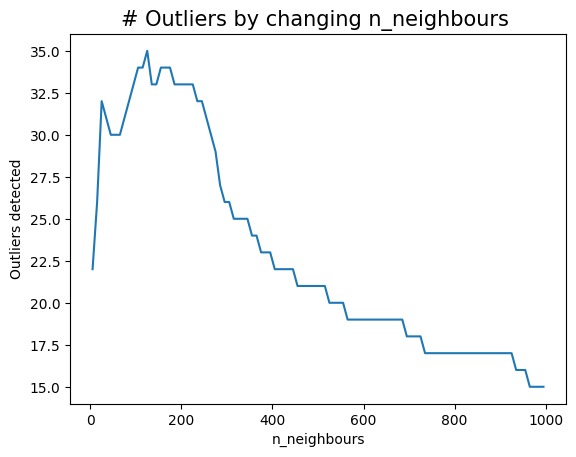

In [ ]:
plt.plot(neighbours, lof_outs)
plt.title("# Outliers by changing n_neighbours ",fontsize=15)
plt.ylabel("Outliers detected")
plt.xlabel('n_neighbours')
plt.show()

In [ ]:
clf=LocalOutlierFactor(n_neighbors=190)
lof_outliers = clf.fit_predict(df_norm)
print(df_norm.shape)
out_lof=np.where(lof_outliers==-1)
np.unique(lof_outliers, return_counts=True)

(1828, 54)


(array([-1,  1]), array([  37, 1791]))

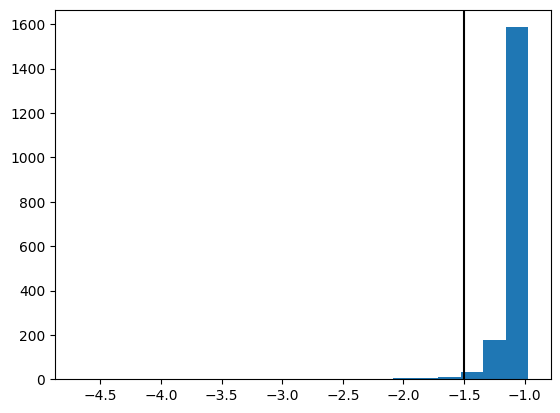

In [ ]:
plt.hist(clf.negative_outlier_factor_, bins=20)
plt.axvline(np.min(clf.negative_outlier_factor_[np.where(lof_outliers==1)]), c='k')
plt.show()

### COF

In [ ]:
pip install --upgrade pyod

In [ ]:
from pyod.models.cof import COF

In [ ]:
cof_=COF(n_neighbors=20)
cof_outliers = cof_.fit_predict(df_norm)
out_cof=np.where(cof_outliers==1)
np.unique(cof_outliers, return_counts=True)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function fit_predict is deprecated
  warnings.warn(msg, category=FutureWarning)


(array([0, 1]), array([1645,  183]))

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
pca = PCA(n_components=2)
pca.fit(df_norm)
df_pca = pca.transform(df_norm)

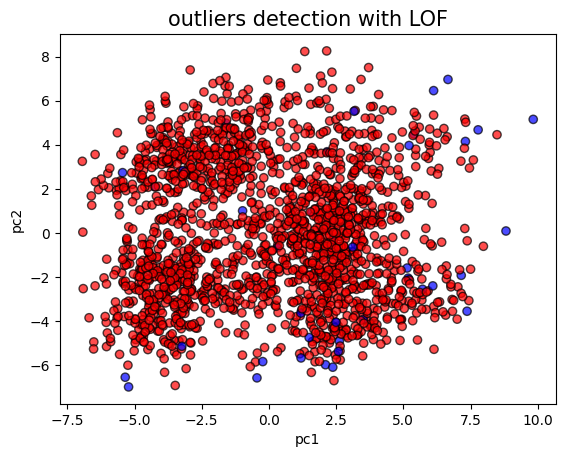

In [ ]:
plt.scatter(df_pca[:, 0], df_pca[:, 1], c=lof_outliers,
            cmap='bwr', edgecolor='k', alpha=0.7)
#plt.cm.prism -colori di prima
plt.xlabel("pc1")
plt.ylabel("pc2")
plt.title("outliers detection with LOF",fontsize=15)

plt.show()

### ISOLATION FOREST

In [ ]:
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split

In [ ]:
clf = IsolationForest(random_state=0 )
clf.fit(df_selected)
clf.predict(df_selected)
if_outliers = clf.predict(df_selected)
if_outliers #For each observation, tells whether or not (+1 or -1) it should be considered as an inlier according to the fitted model.
#-1 sono outliers
out_if=np.where(if_outliers==-1)
np.unique(if_outliers, return_counts=True) # sono 49

(array([-1,  1]), array([  60, 1768]))

In [ ]:
df2=pd.DataFrame(df_norm)

# salvo le due componenti principali che mi servono solo per il plot poi
pca = PCA(n_components=2)
pca.fit(df_norm)
df_pca = pca.transform(df_norm)

pca = PCA(n_components=2)
pca.fit(df_norm)
pca_df2=pd.DataFrame(pca.transform(df_norm), columns=['pc1','pc2'])


model_IF = IsolationForest(random_state=0)
model_IF.fit(df_selected)
df2['anomaly_scores'] = model_IF.decision_function(df_selected)
df2['anomaly'] = model_IF.predict(df_selected)
df2['pc1']=pca_df2['pc1']
df2['pc2']=pca_df2['pc2']


In [ ]:
# attenzione a non far partire due volte queste due prime righe
np.place(cof_outliers, cof_outliers == 1, -1)
np.place(cof_outliers, cof_outliers == 0, 1)


In [ ]:
clf.decision_function(df_selected)

### ABOD

In [ ]:
# pip install pyod

In [ ]:
from pyod.models.abod import ABOD

In [ ]:
#parametro contamination is the proportion of outliers in the data set, default 0.1 (10% dei dati sono outliers)

clf = ABOD(0.02, n_neighbors= 10, method = 'fast')  # contamination = 0.02
clf.fit(df_norm)

ABOD(contamination=0.02, method='fast', n_neighbors=10)

In [ ]:
abod_outliers = clf.predict(df_norm)
np.unique(abod_outliers, return_counts=True)

(array([0, 1]), array([1792,   36]))

In [ ]:
clf.decision_scores_

array([-3.19040639e-07, -2.37049663e-05, -2.32997458e-04, ...,
       -8.98430802e-05, -5.42932266e-05, -1.29443069e-05])

In [ ]:
# lista delle osservazioni che sono risultate outliers usando abod
out_abod = np.where(clf.labels_ == 1)

In [ ]:
# attenzione a non far partire due volte queste due prime righe
np.place(abod_outliers, abod_outliers == 1, -1)
np.place(abod_outliers, abod_outliers == 0, 1)


In [ ]:
from matplotlib import rcParams

In [ ]:
# plt.hist(clf.decision_scores_, bins=35, rwidth=0.9)
# rcParams['figure.figsize'] = 11.7,8.27
# plt.axvline(np.min(clf.decision_scores_[np.where(abod_outliers==-1)]), c='navy', ls = '--', lw = 1.2 )
# plt.xlim(-0.0018,0)
# plt.title('add title', fontsize=15)
# plt.show()

In [ ]:
## ABOD al variare di k = numero di nearest neighbours
num_outliers = []
n_neighbours = list(range(5, 150, 10))
for k in n_neighbours:
    clf = ABOD(method='fast', n_neighbors = k, contamination = 0.02)
    clf.fit(df_norm)
    outliers = clf.predict(df_norm)
    num_outliers.append(np.count_nonzero(outliers == 1))



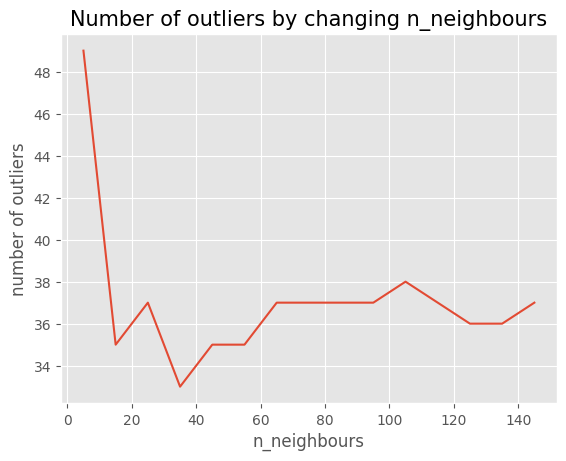

In [ ]:
plt.plot(n_neighbours, num_outliers)
plt.title('Number of outliers by changing n_neighbours', fontsize=15)
plt.xlabel('n_neighbours')
plt.ylabel('number of outliers')
tight_layout=True
plt.show()

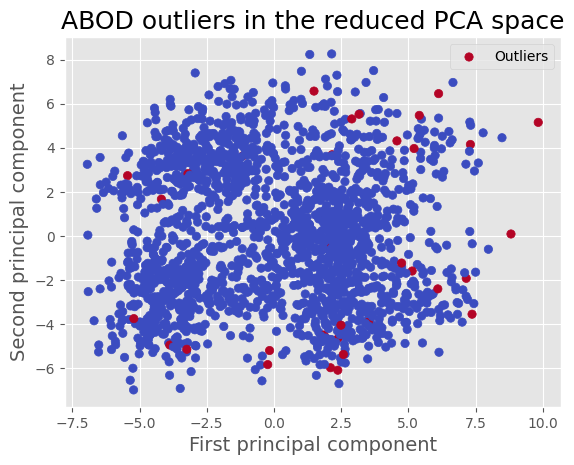

In [ ]:
# plot ABOD - outliers individuati in rosso (PCA)
plt.scatter(df_pca[:, 0], df_pca[:, 1], c=abod_outliers, cmap='coolwarm', label ='Outliers')
plt.title('ABOD outliers in the reduced PCA space', fontsize = 18)
plt.xlabel('First principal component', fontsize = 14)
plt.ylabel('Second principal component', fontsize = 14)
plt.legend()
plt.show()

### Final comprehensive plots of outliers

In [ ]:
from collections import Counter

In [ ]:
#qua trasformiamo tutto il lista per applicare la funzione counter
out_lof_list = (out_lof[0]).tolist()
out_cof_list = (out_cof[0]).tolist()
out_if_list = (out_if[0]).tolist()
out_abod_list = (out_abod[0]).tolist()

ciao = out_lof_list + out_cof_list + out_if_list + out_abod_list #lista di tutte le osservazioni outliers
diz = Counter(ciao) #contiamo quante volte si ripetono gli outliers nei 4 metodi
mega_outliers=[] #lista che riempiamo con gli outliers che si ripetono per almeno 3 volte
for el in diz:
  if diz[el]>=3:
   mega_outliers.append(el)


In [ ]:
#tsne
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)
df_tsne = tsne.fit_transform(df_selected)


In [ ]:
# le liste di outliers con -1 se outliers e 1 se inliers sono:
#- abod_outliers
#- cof_outliers
#- lof_outliers
#- if_outliers
#ora creo un dataframe con dentro anche queste colonne che servirà solamente a fare i grafici

df_plot=pd.DataFrame(df_selected, columns=selected)
df_plot['abod_outliers']=abod_outliers
df_plot['cof_outliers']=cof_outliers
df_plot['lof_outliers']=lof_outliers
df_plot['if_outliers']=if_outliers
df_plot['pc1']=pca_df2['pc1']
df_plot['pc2']=pca_df2['pc2']
df_plot['tse1']=df_tsne[:,0]
df_plot['tsne2']=df_tsne[:,1]
# voglio creare una colonna con scrito outlier se è outlier
col_outliers=['inliers']*1828
df_plot['outliers']=col_outliers
df_plot.loc[mega_outliers,'outliers'] = 'mega_outliers'
df_plot.loc[(df_plot['if_outliers']==-1) & (df_plot['outliers']=='inliers'),'outliers'] = '0'
df_plot.loc[(df_plot['lof_outliers']==-1) & (df_plot['outliers']=='inliers'),'outliers'] = '1'
df_plot.loc[(df_plot['cof_outliers']==-1) & (df_plot['outliers']=='inliers'),'outliers'] = '2'
df_plot.loc[(df_plot['abod_outliers']==-1) & (df_plot['outliers']=='inliers'),'outliers'] = '3'
df_plot.loc[(df_plot['outliers']=='inliers'),'outliers'] = '4'
df_plot.loc[(df_plot['outliers']=='mega_outliers'),'outliers'] = '5'
df_plot['emotion']=emotion_train



In [ ]:
df_plot1=pd.DataFrame(df_selected, columns=selected)
df_plot['abod_outliers']=abod_outliers
df_plot['cof_outliers']=cof_outliers
df_plot['lof_outliers']=lof_outliers
df_plot['if_outliers']=if_outliers
# voglio creare una colonna con scrito outlier se è outlier
col_outliers=['inliers']*1828
df_plot['outliers']=col_outliers
df_plot.loc[(df_plot['if_outliers']==-1) & (df_plot['outliers']=='inliers'),'outliers'] = 'if_outliers'
df_plot.loc[(df_plot['lof_outliers']==-1) & (df_plot['outliers']=='inliers'),'outliers'] = 'lof_outliers'
df_plot.loc[(df_plot['cof_outliers']==-1) & (df_plot['outliers']=='inliers'),'outliers'] = 'cof_outliers'
df_plot.loc[(df_plot['abod_outliers']==-1) & (df_plot['outliers']=='inliers'),'outliers'] = 'abod_outliers'
df_plot.loc[(df_plot['outliers']=='inliers'),'outliers'] = '4'
df_plot['emotion']=emotion_train
df_plot = df_plot[df_plot['outliers']!='4']


In [ ]:
df_plot.shape

(221, 64)

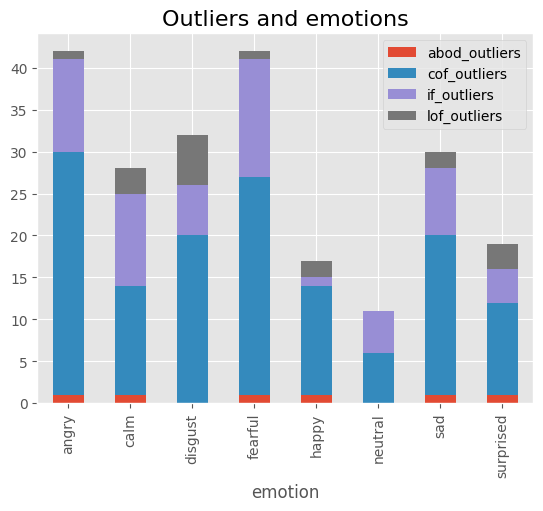

In [ ]:
df_plot1=df_plot.iloc[:,62:64]
df_plot1.groupby('emotion')['outliers']\
    .value_counts(normalize=False)\
    .unstack(level=1)\
    .plot.bar(stacked=True)
plt.legend(loc='upper right')
plt.style.use('ggplot')
plt.title('Outliers and emotions', fontsize = 16)
plt.show()

<ipython-input-52-fa7479f26cb6>:5: UserWarning: The markers list has more values (6) than needed (4), which may not be intended.
  scatter=sns.scatterplot(data=df_plot,x='pc1', y='pc2', hue='outliers', palette="Set2", markers=["X","o","^",'p',"D","s"],style='outliers',s=100)


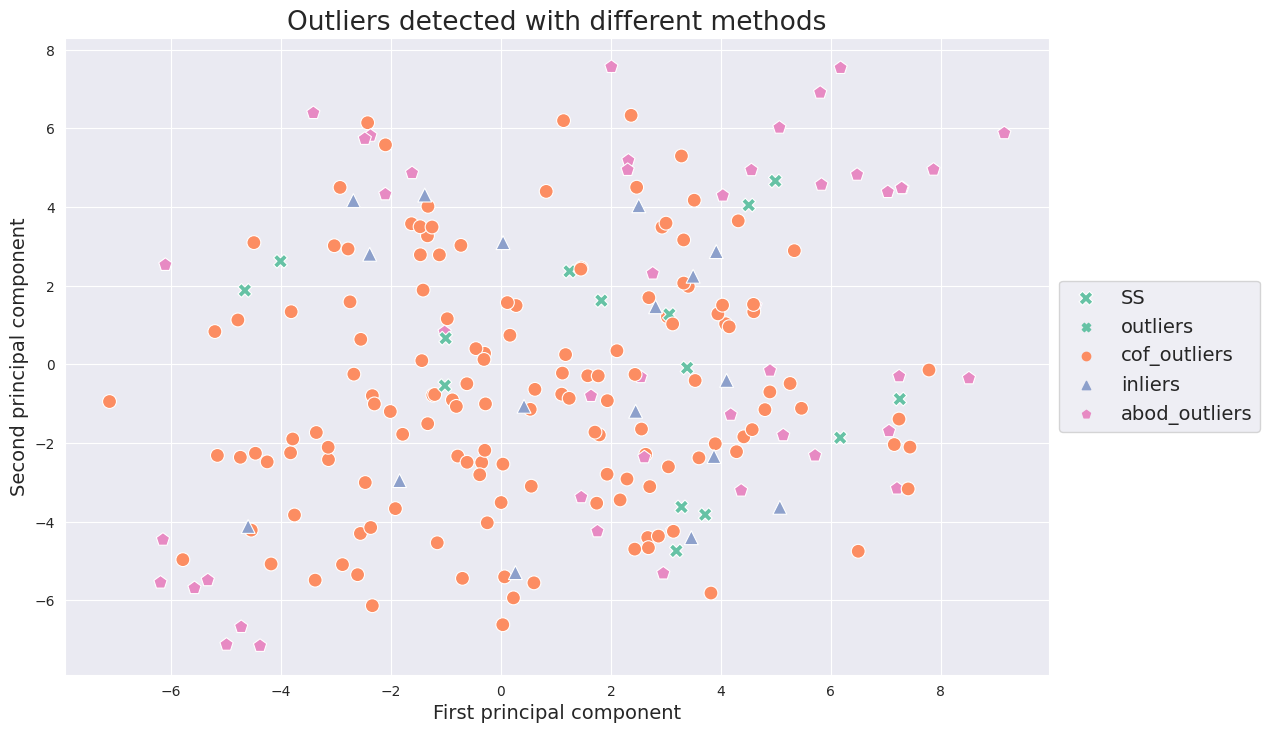

In [ ]:
from matplotlib import rcParams

# figure size in inches
rcParams['figure.figsize'] = 12.7,8.27
scatter=sns.scatterplot(data=df_plot,x='pc1', y='pc2', hue='outliers', palette="Set2", markers=["X","o","^",'p',"D","s"],style='outliers',s=100)
#['outliers','cof_outliers','inliers','abod_outliers','if_outliers','lof_outliers']
scatter.legend(['SS','outliers','cof_outliers','inliers','abod_outliers','if_outliers','lof_outliers'],loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 14)
sns.set_style('darkgrid')
plt.title('Outliers detected with different methods',fontsize=19)
plt.xlabel('First principal component', fontsize = 14)
plt.ylabel('Second principal component', fontsize = 14)
plt.show()


<ipython-input-54-18beaf208388>:5: UserWarning: The markers list has more values (6) than needed (4), which may not be intended.
  scatter=sns.scatterplot(data=df_plot,x='tse1', y='tsne2', hue='outliers', palette="Set2", markers=["X","o","^",'p',"D","s"],style='outliers',s=100)


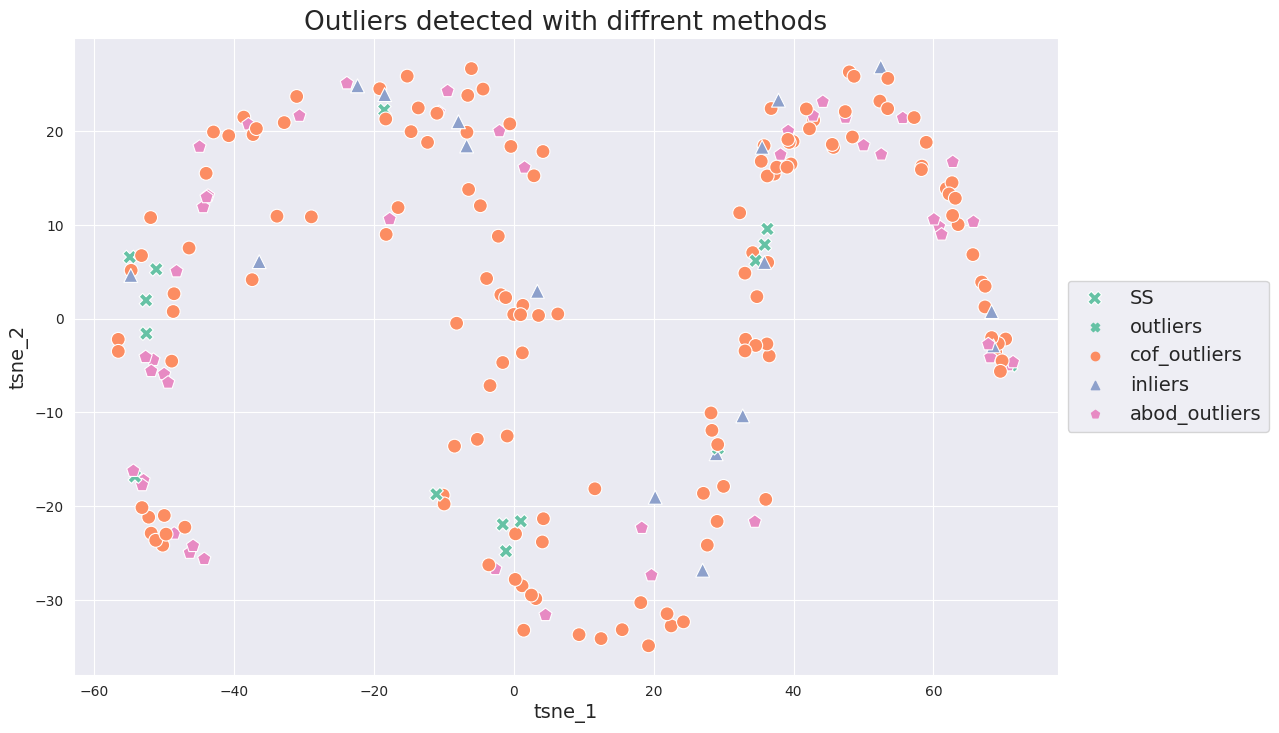

In [ ]:
from matplotlib import rcParams

# figure size in inches
rcParams['figure.figsize'] = 12.7,8.27
scatter=sns.scatterplot(data=df_plot,x='tse1', y='tsne2', hue='outliers', palette="Set2", markers=["X","o","^",'p',"D","s"],style='outliers',s=100)
#['outliers','cof_outliers','inliers','abod_outliers','if_outliers','lof_outliers']
scatter.legend(['SS','outliers','cof_outliers','inliers','abod_outliers','if_outliers','lof_outliers'],loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 14)
sns.set_style('darkgrid')
plt.title('Outliers detected with diffrent methods',fontsize=19)
plt.xlabel('tsne_1', fontsize = 14)
plt.ylabel('tsne_2', fontsize = 14)
plt.show()

In [ ]:
selected_and_cat=['modality', 'vocal_channel', 'emotion', 'emotional_intensity',
       'statement', 'repetition', 'actor', 'sex','filename','kur',
 'lag1_kur',
 'mfcc_q05',
 'mfcc_q95',
 'mfcc_kur',
 'sc_q50',
 'sc_q75',
 'stft_sum',
 'kur_w1',
 'lag1_kur_w1',
 'mfcc_std_w1',
 'mfcc_q99_w1',
 'sc_std_w1',
 'kur_w2',
 'zc_sum_w2',
 'mfcc_sum_w2',
 'mfcc_std_w2',
 'mfcc_q01_w2',
 'mfcc_q05_w2',
 'mfcc_q99_w2',
 'mfcc_kur_w2',
 'mfcc_skew_w2',
 'sc_q05_w2',
 'sc_q25_w2',
 'sc_q50_w2',
 'sc_q99_w2',
 'sc_kur_w2',
 'sc_skew_w2',
 'stft_sum_w2',
 'kur_w3',
 'lag1_skew_w3',
 'zc_sum_w3',
 'mfcc_sum_w3',
 'mfcc_mean_w3',
 'mfcc_q01_w3',
 'mfcc_q25_w3',
 'mfcc_kur_w3',
 'sc_std_w3',
 'sc_min_w3',
 'sc_q01_w3',
 'sc_q50_w3',
 'sc_q95_w3',
 'stft_sum_w3',
 'stft_kur_w3',
 'kur_w4',
 'lag1_kur_w4',
 'lag1_skew_w4',
 'mfcc_max_w4',
 'mfcc_q95_w4',
 'mfcc_q99_w4',
 'sc_sum_w4',
 'sc_min_w4',
 'sc_skew_w4',
 'stft_sum_w4',
 'stft_kur_w4']

In [ ]:
df_final=df_train_csv[selected]
df_final_cat=df_train_csv[selected_and_cat]

In [ ]:

df_final= df_final.drop(df_final.index[[mega_outliers]])   #rimozione dei mega outliers dal dataset
df_final_cat=df_final_cat.drop(df_final_cat.index[[mega_outliers]])

# df_final è numerico
# df_final_cat è intero sia cat che num

/usr/local/lib/python3.9/dist-packages/pandas/core/indexes/base.py:5339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)


In [ ]:
# df_final E' QUELLO GIUSTO!!!

# splitting df_final
emotion = df_final_cat['emotion']
df_final_train, df_final_test, emotion_train, emotion_test = train_test_split(
    df_final, emotion, test_size=0.3, random_state=0
)

In [ ]:
# normalizzato intero
sc = StandardScaler()
df_final_norm = sc.fit_transform(df_final)  # normalizzato intero

In [ ]:
# normalizzare df_final_train e df_final_test separatamente
sc.fit(df_final_train)
df_final_train_norm = sc.transform(df_final_train)   # normalizzato a pezzi
df_final_test_norm = sc.transform(df_final_test)

## IMBALANCED LEARNING
Here we'll explore different techniques to handle situations where classes are highly imbalanced. 
For each method we'll compare the performance of a decision tree trained on the imbalanced space and then trained on the balanced one. 

Oversampling techniques: 
- ADASYN
- SMOTE

Undersampling techniques: 
- Random Undersampling
- Condensed Nearest Neighbours 
- Tomek Links 



In [ ]:
# here we're creating our ''imbalanced dataset'' 

# mappo emotion_train_train ed emotion_train_test in 0(not surprised) - 1(surprised)

my_dict = {'angry': 0, 'neutral': 0, 'happy' : 0, 'sad' : 0, 'fearful' : 0, 'calm' : 0, 'disgust' : 0, 'surprised' : 1}
emotion_train_bin = emotion_train.map(my_dict)
emotion_test_bin = emotion_test.map(my_dict)

In [ ]:
(np.unique(emotion_train_bin, return_counts=True)[1] / len(emotion_train_bin))
# abbiamo il 93% dei record di classe "not surprised" e il 7 percento di record di classe "surprised"

array([0.93095238, 0.06904762])

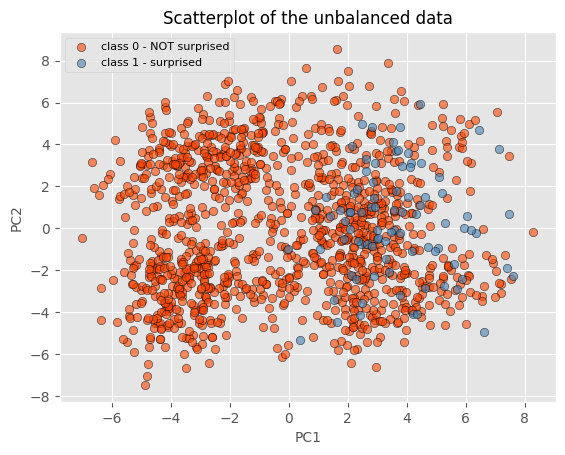

In [ ]:
# scatter plot sul dataset sbilanciato - pca
pca = PCA(n_components=2)
pca.fit(df_final_train_norm)
X_pca = pca.transform(df_final_train_norm)

# Create scatterplot for each class with a label
plt.scatter(X_pca[emotion_train_bin==0, 0], X_pca[emotion_train_bin==0, 1], c='orangered', edgecolor='k', alpha=0.6, label='class 0 - NOT surprised')
plt.scatter(X_pca[emotion_train_bin==1, 0], X_pca[emotion_train_bin==1, 1], c='steelblue', edgecolor='k', alpha=0.6, label='class 1 - surprised')

# Create automatic legend based on labels specified in scatter() function
plt.legend(loc='upper left', fontsize = 8)
plt.title('Scatterplot of the unbalanced data', fontsize= 12)
plt.xlabel('PC1', fontsize = 10)
plt.ylabel('PC2', fontsize = 10)
plt.style.use('ggplot')
plt.show()

### OVERSAMPLING

#### Oversampling 1 - SMOTE

In [ ]:
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(df_final_train_norm, emotion_train_bin)  #X_res e y_res to store the resampled dataset
print('Resampled dataset shape %s' % Counter(y_res))   # Resampled dataset shape Counter({0: 1177, 1: 1177})

Resampled dataset shape Counter({0: 1173, 1: 1173})


In [ ]:
# ogni volta serve applicare il transform alla PCA su training resampled
pca = PCA(n_components=2)
pca.fit(df_final_norm)
X_pca = pca.transform(X_res)

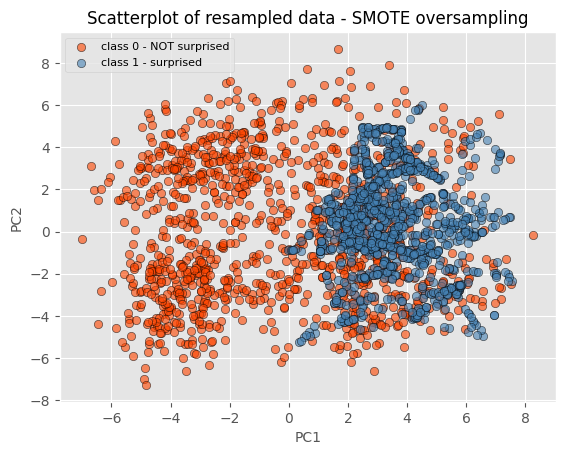

In [ ]:
# Create scatterplot for each class with a label
plt.scatter(X_pca[y_res==0, 0], X_pca[y_res==0, 1], c='orangered', edgecolor='k', alpha=0.6, label='class 0 - NOT surprised')
plt.scatter(X_pca[y_res==1, 0], X_pca[y_res==1, 1], c='steelblue', edgecolor='k', alpha=0.6, label='class 1 - surprised')

# Create automatic legend based on labels specified in scatter() function
plt.legend(loc='upper left', fontsize = 8)
plt.title('Scatterplot of resampled data - SMOTE oversampling', fontsize= 12)
plt.xlabel('PC1', fontsize = 10)
plt.ylabel('PC2', fontsize = 10)
plt.style.use('ggplot')
plt.show()


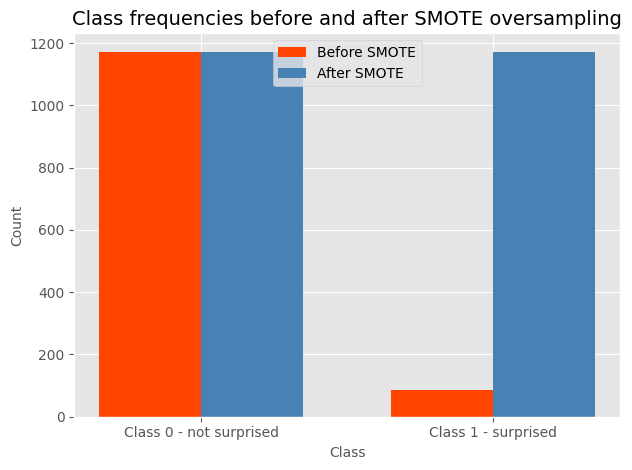

In [ ]:
# trovo il count dei record di ogni classe prima e dopo SMOTE
class_counts_before = Counter(emotion_train_bin)
class_counts_after = Counter(y_res)

# plotto class distribution before and after SMOTE
labels = ['Class 0 - not surprised', 'Class 1 - surprised']
counts_before = [class_counts_before[0], class_counts_before[1]]
counts_after = [class_counts_after[0], class_counts_after[1]]

x = [0, 1]
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar([val - width/2 for val in x], counts_before, width, color = 'orangered', label='Before SMOTE')
rects2 = ax.bar([val + width/2 for val in x], counts_after, width, color = 'steelblue', label='After SMOTE')

ax.set_xlabel('Class', fontsize = 10)
ax.set_ylabel('Count', fontsize = 10)
ax.set_xticks(x)
ax.set_title('Class frequencies before and after SMOTE oversampling', fontsize = 14)
ax.set_xticklabels(labels)
ax.legend(loc='upper center', fontsize = 10)
plt.style.use('ggplot')
fig.tight_layout()

plt.show()

In [ ]:
# Valuto l'efficacia guardando le performance di un classificatore allenato sullo spazio resampled
# Lo faccio per Decision Tree
# i parametri NON sono quelli trovati sopra durante feature selection
# ottimizzo di nuovo i parametri sul nuovo training set resampled

# tuning parametri
param_grid = {
    "min_samples_split": loguniform(1e-2, 1e0),
    "min_samples_leaf": uniform(0.001, 0.2),
    "max_depth": randint(2, 200),
    "criterion": ["gini", "entropy"],
}
grid = RandomizedSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_distributions=param_grid,
    cv=RepeatedStratifiedKFold(random_state=42),
    n_jobs=-1,
    n_iter=10,
)
grid.fit(X_res, y_res)
clf_tuned = grid.best_estimator_
print(grid.best_params_, grid.best_score_)

{'criterion': 'gini', 'max_depth': 182, 'min_samples_leaf': 0.0012721409501873717, 'min_samples_split': 0.10048593131430794} 0.8686687837408701


In [ ]:
# classification report del decision tree trained sul resampled data space using SMOTE
y_pred = clf_tuned.predict(df_final_test_norm)
print('Accuracy %s' % accuracy_score(emotion_test_bin, y_pred))
print('F1-score %s' % f1_score(emotion_test_bin, y_pred, average=None))
print(classification_report(emotion_test_bin, y_pred))

Accuracy 0.8685185185185185
F1-score [0.9251844  0.45801527]
              precision    recall  f1-score   support

           0       0.95      0.90      0.93       488
           1       0.38      0.58      0.46        52

    accuracy                           0.87       540
   macro avg       0.67      0.74      0.69       540
weighted avg       0.90      0.87      0.88       540



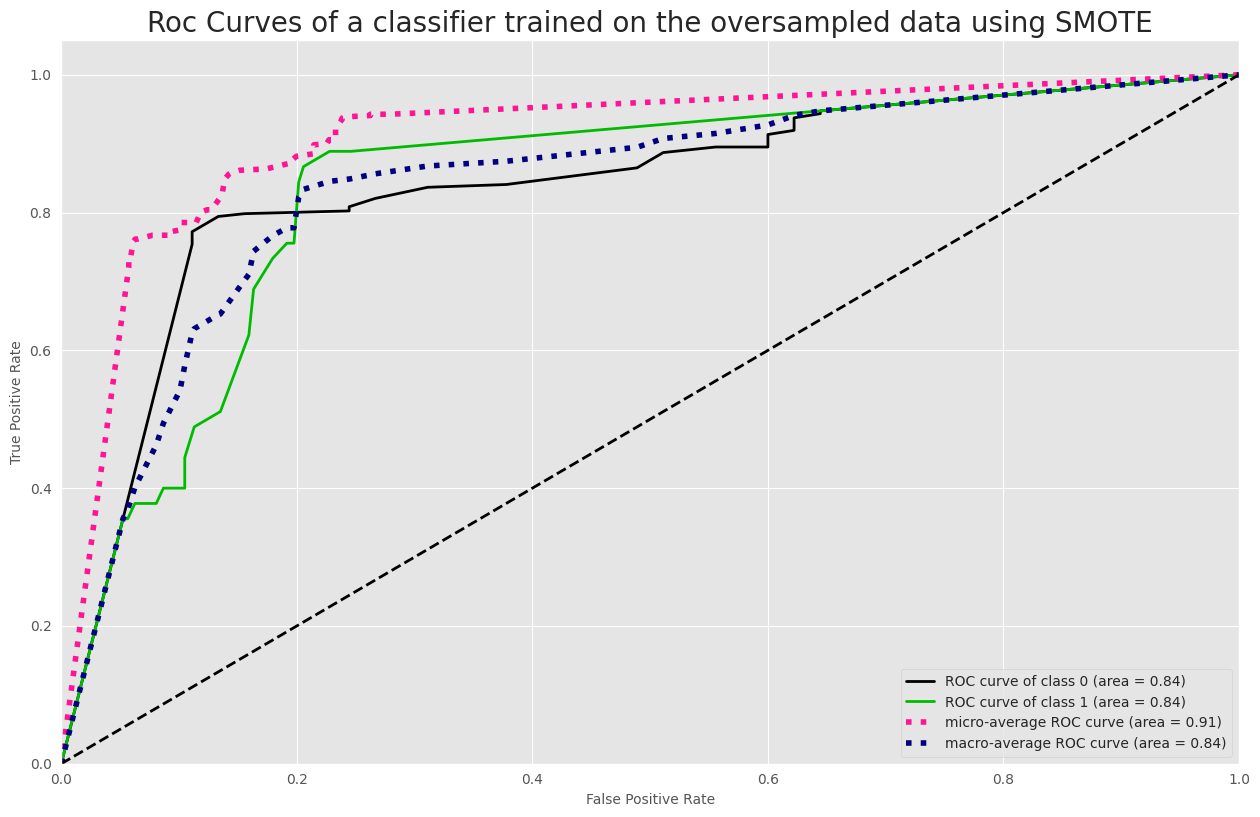

In [ ]:
# roc curve
y_score = clf_tuned.predict_proba(df_final_test_norm)
plot_roc(emotion_test_bin, y_score)
plt.title("Roc Curves of a classifier trained on the oversampled data using SMOTE", fontsize = 20)
plt.tight_layout()
plt.style.use('ggplot')
plt.show()

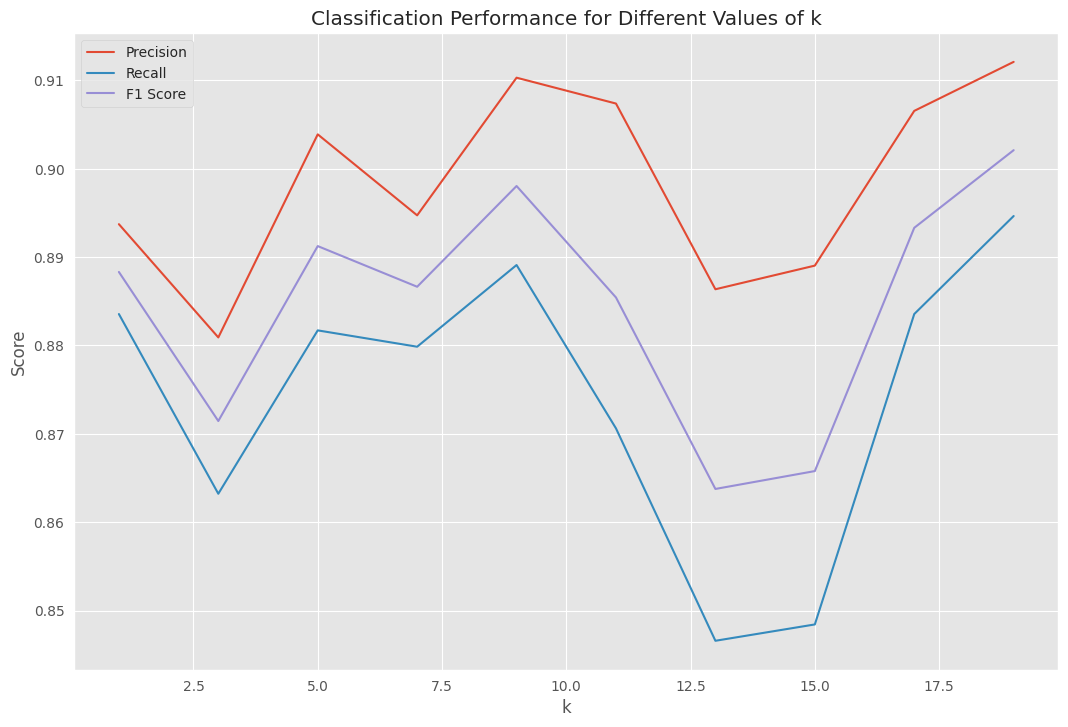

In [ ]:
# Train a decision tree classifier with SMOTE oversampling using different values of k
# Define the values of k to test
k_values = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19]
precision_scores = []
recall_scores = []
f1_scores = []
for k in k_values:
   # #print(f'K = {k}')
    smote = SMOTE(sampling_strategy='minority', k_neighbors=k)
    X_res, y_res = smote.fit_resample(df_final_train_norm, emotion_train_bin)
    clf = DecisionTreeClassifier()
    clf.fit(X_res, y_res)
    y_pred = clf.predict(df_final_test_norm)
    report = classification_report(emotion_test_bin, y_pred, output_dict=True)
    precision_scores.append(report['weighted avg']['precision'])
    recall_scores.append(report['weighted avg']['recall'])
    f1_scores.append(report['weighted avg']['f1-score'])

# Plot the precision, recall, and F1 scores for each value of k
plt.plot(k_values, precision_scores, label='Precision')
plt.plot(k_values, recall_scores, label='Recall')
plt.plot(k_values, f1_scores, label='F1 Score')
plt.title('Classification Performance for Different Values of k')
plt.xlabel('k')
plt.ylabel('Score')
plt.legend()
plt.show()

In [ ]:
# performance del classificatore sul training sbilanciato
clf_sbilanciato = DecisionTreeClassifier(criterion='gini', max_depth=81, min_samples_leaf=0.0022527488754068062, min_samples_split=0.010817277658158644)
clf_sbilanciato.fit(df_final_train_norm, emotion_train_bin)

y_pred = clf.predict(df_final_test_norm)

print('Accuracy %s' % accuracy_score(emotion_test_bin, y_pred))
print('F1-score %s' % f1_score(emotion_test_bin, y_pred, average=None))
print(classification_report(emotion_test_bin, y_pred))

Accuracy 0.9037037037037037
F1-score [0.94941634 0.        ]
              precision    recall  f1-score   support

           0       0.90      1.00      0.95       488
           1       0.00      0.00      0.00        52

    accuracy                           0.90       540
   macro avg       0.45      0.50      0.47       540
weighted avg       0.82      0.90      0.86       540



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Oversampling 2 - ADASYN

In [ ]:
ada = ADASYN(random_state=42)
X_res_ada, y_res_ada = ada.fit_resample(df_final_train_norm, emotion_train_bin)
print('Resampled dataset shape %s' % Counter(y_res_ada))

Resampled dataset shape Counter({1: 1183, 0: 1173})


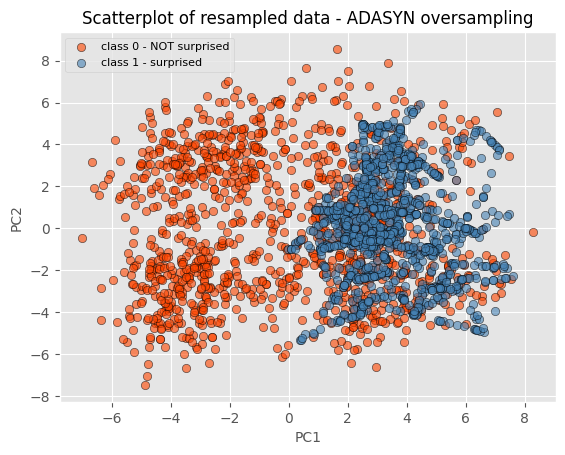

In [ ]:
#PCA ADA
pca_ADA = PCA(n_components=2)
pca_ADA.fit(df_final_norm)
X_pca_ADA = pca.transform(X_res_ada)

# scatterplot per ogni classe
plt.scatter(X_pca_ADA[y_res_ada==0, 0], X_pca_ADA[y_res_ada==0, 1], c='orangered', edgecolor='k', alpha=0.6, label='class 0 - NOT surprised')
plt.scatter(X_pca_ADA[y_res_ada==1, 0], X_pca_ADA[y_res_ada==1, 1], c='steelblue', edgecolor='k', alpha=0.6, label='class 1 - surprised')

# Create automatic legend based on labels specified in scatter() function
plt.legend(loc='upper left', fontsize = 8)
plt.title('Scatterplot of resampled data - ADASYN oversampling', fontsize= 12)
plt.xlabel('PC1', fontsize = 10)
plt.ylabel('PC2', fontsize = 10)
plt.style.use('ggplot')
plt.show()

In [ ]:
# Valuto l'efficacia di ADASYIN guardando le performance di un classificatore allenato sullo spazio resampled
# Lo faccio per Decision Tree
# i parametri NON sono quelli trovati sopra durante feature selection
# ottimizzo di nuovo i parametri sul nuovo training set resampled

# tuning parametri
param_grid = {
    "min_samples_split": loguniform(1e-2, 1e0),
    "min_samples_leaf": uniform(0.001, 0.2),
    "max_depth": randint(2, 200),
    "criterion": ["gini", "entropy"],
}
grid = RandomizedSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_distributions=param_grid,
    cv=RepeatedStratifiedKFold(random_state=42),
    n_jobs=-1,
    n_iter=10,
)
grid.fit(X_res_ada, y_res_ada)
clf_ada = grid.best_estimator_
print(grid.best_params_, grid.best_score_)

{'criterion': 'gini', 'max_depth': 107, 'min_samples_leaf': 0.042893686361047116, 'min_samples_split': 0.011926919553784235} 0.850488322717622


In [ ]:
## checking performances of ada using a classifier trained on the resample ada space.

y_pred_ada = clf_ada.predict(df_final_test_norm)

print('Accuracy %s' % accuracy_score(emotion_test_bin, y_pred_ada))
print('F1-score %s' % f1_score(emotion_test_bin, y_pred_ada, average=None))
print(classification_report(emotion_test_bin, y_pred_ada))

Accuracy 0.8521256931608133
F1-score [0.91525424 0.42028986]
              precision    recall  f1-score   support

           0       0.96      0.87      0.92       496
           1       0.31      0.64      0.42        45

    accuracy                           0.85       541
   macro avg       0.64      0.76      0.67       541
weighted avg       0.91      0.85      0.87       541



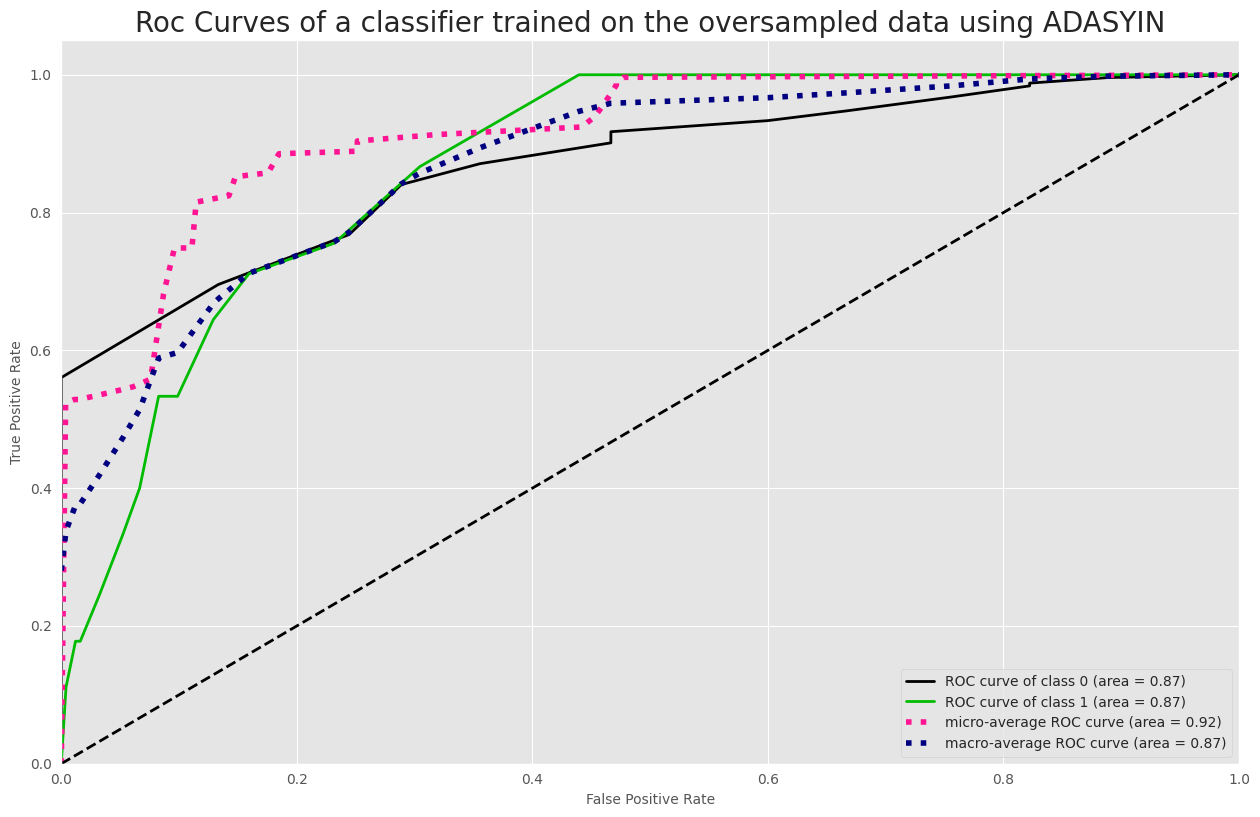

In [ ]:
y_score_ada = clf_ada.predict_proba(df_final_test_norm)
plot_roc(emotion_test_bin, y_score_ada)
plt.title("Roc Curves of a classifier trained on the oversampled data using ADASYIN", fontsize=20)
plt.tight_layout()
plt.show()

### UNDERSAMPLING

#### Undersampling 1 - Random Undersampling


In [ ]:
#pip install -U imbalanced-learn

from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import CondensedNearestNeighbour
from imblearn.under_sampling import TomekLinks
from imblearn.under_sampling import EditedNearestNeighbours

In [ ]:
grid = RandomizedSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_distributions=param_grid,
    cv=RepeatedStratifiedKFold(random_state=42),
    n_jobs=-1,
    n_iter=100,
)
grid.fit(df_final_train_norm, emotion_train_bin)
clf_base = grid.best_estimator_
print(grid.best_params_, grid.best_score_)

{'criterion': 'entropy', 'max_depth': 39, 'min_samples_leaf': 0.1300470235212115, 'min_samples_split': 0.14762579627476605} 0.9271033314511575


In [ ]:
#clf.fit(df_final_train, emotion_train_bin)   # performance su dataset sbilanciato

emo_pred_ub = clf_base.predict(df_final_test_norm)

print('Accuracy %s' % accuracy_score(emotion_test_bin, emo_pred_ub))
print('F1-score %s' % f1_score(emotion_test_bin, emo_pred_ub, average=None))
print(classification_report(emotion_test_bin, emo_pred_ub))

Accuracy 0.9168207024029574
F1-score [0.95660559 0.        ]
              precision    recall  f1-score   support

           0       0.92      1.00      0.96       496
           1       0.00      0.00      0.00        45

    accuracy                           0.92       541
   macro avg       0.46      0.50      0.48       541
weighted avg       0.84      0.92      0.88       541



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
rand_us = RandomUnderSampler(random_state=42)
X_rreb, y_rreb = rand_us.fit_resample(df_final_train_norm, emotion_train_bin)
print('Resampled dataset shape %s' % Counter(y_rreb))

Resampled dataset shape Counter({0: 92, 1: 92})


In [ ]:
grid = RandomizedSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_distributions=param_grid,
    cv=RepeatedStratifiedKFold(random_state=42),
    n_jobs=-1,
    n_iter=100,
)
grid.fit(X_rreb, y_rreb)
clf_ru = grid.best_estimator_
print(grid.best_params_, grid.best_score_)

{'criterion': 'entropy', 'max_depth': 198, 'min_samples_leaf': 0.054650392966613476, 'min_samples_split': 0.6976239552503251} 0.8173723723723725


In [ ]:
#clf.fit(X_rreb, y_rreb)

y_pred_rreb = clf_ru.predict(df_final_test_norm)

print('Accuracy %s' % accuracy_score(emotion_test_bin, y_pred_rreb))
print('F1-score %s' % f1_score(emotion_test_bin, y_pred_rreb, average=None))
print(classification_report(emotion_test_bin, y_pred_rreb))

Accuracy 0.6635859519408502
F1-score [0.77696078 0.31578947]
              precision    recall  f1-score   support

           0       0.99      0.64      0.78       496
           1       0.19      0.93      0.32        45

    accuracy                           0.66       541
   macro avg       0.59      0.79      0.55       541
weighted avg       0.92      0.66      0.74       541



#### Undersampling 2 : CondensedNN

In [ ]:
cnn = CondensedNearestNeighbour(random_state=44, n_jobs=10, n_neighbors=71)
X_cnn_reb, y_cnn_reb = cnn.fit_resample(df_final_train_norm, emotion_train_bin)
print('Resampled dataset shape %s' % Counter(y_cnn_reb))

Resampled dataset shape Counter({0: 149, 1: 92})


In [ ]:
grid = RandomizedSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_distributions=param_grid,
    cv=RepeatedStratifiedKFold(random_state=42),
    n_jobs=-1,
    n_iter=100,
)
grid.fit(X_cnn_reb, y_cnn_reb)
clf_cnn = grid.best_estimator_
print(grid.best_params_, grid.best_score_)

{'criterion': 'entropy', 'max_depth': 103, 'min_samples_leaf': 0.023092792165387843, 'min_samples_split': 0.04548992232044803} 0.6660714285714286


In [ ]:
#clf.fit(X_cnn_reb, y_cnn_reb)

y_pred_cnn_reb = clf_cnn.predict(df_final_test_norm)

print('Accuracy %s' % accuracy_score(emotion_test_bin, y_pred_cnn_reb))
print('F1-score %s' % f1_score(emotion_test_bin, y_pred_cnn_reb, average=None))
print(classification_report(emotion_test_bin, y_pred_cnn_reb))

Accuracy 0.8410351201478743
F1-score [0.90985325 0.328125  ]
              precision    recall  f1-score   support

           0       0.95      0.88      0.91       496
           1       0.25      0.47      0.33        45

    accuracy                           0.84       541
   macro avg       0.60      0.67      0.62       541
weighted avg       0.89      0.84      0.86       541



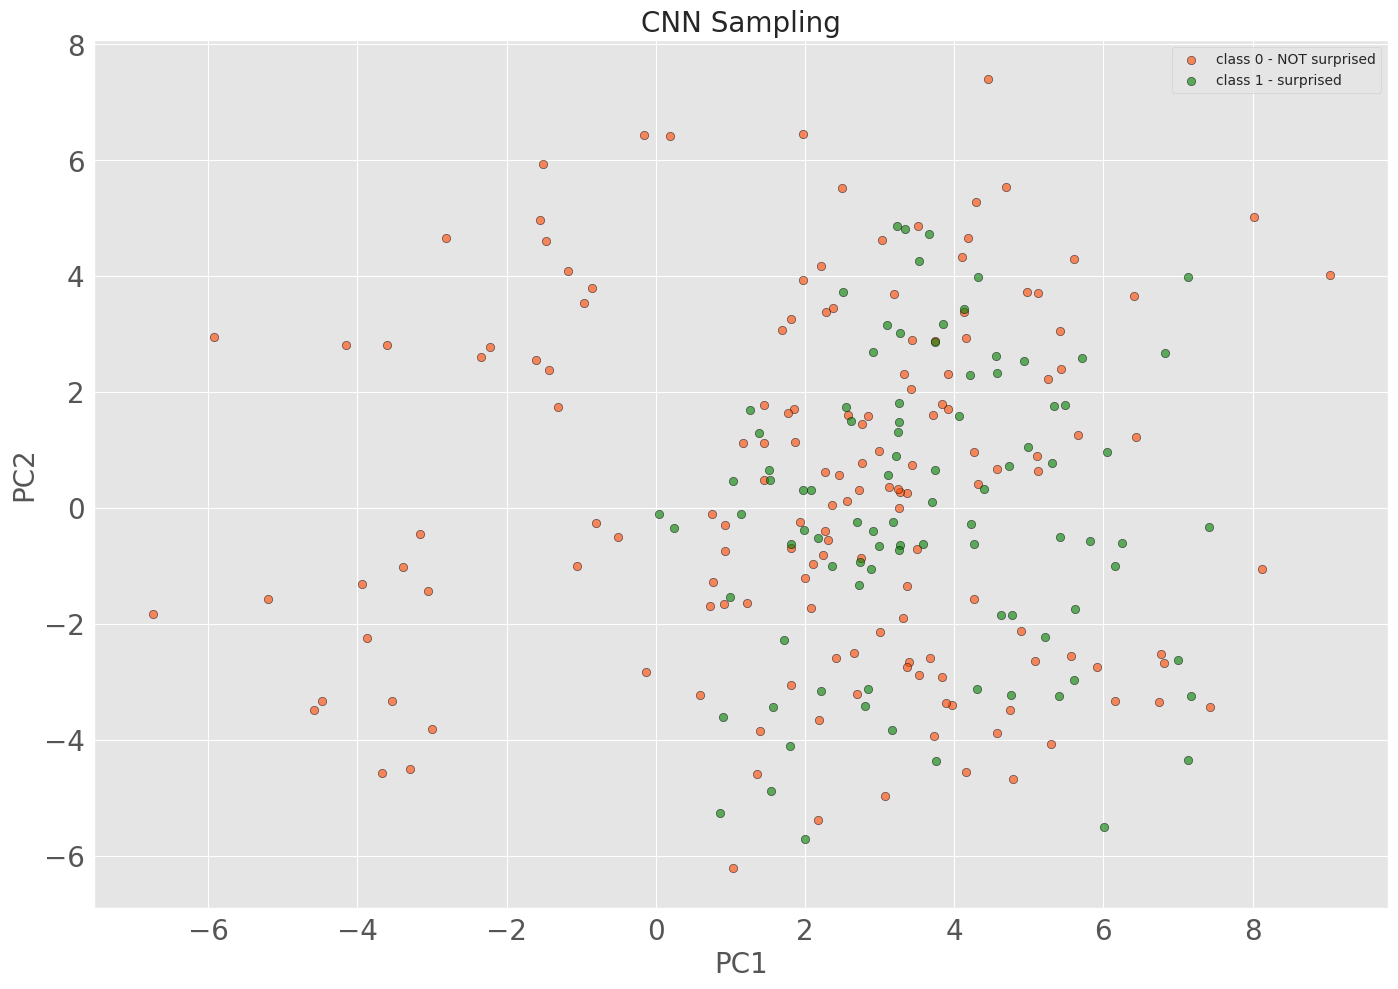

<Figure size 600x400 with 0 Axes>

In [ ]:
pca_cnn = PCA(n_components=2)
pca_cnn.fit(df_final_train_norm)
X_pca_cnn = pca.transform(X_cnn_reb)
fig,ax = plt.subplots()

plt.scatter(X_pca_cnn[y_cnn_reb==0,0], X_pca_cnn[y_cnn_reb==0, 1], c='orangered', edgecolor='k', alpha=0.6, label='class 0 - NOT surprised')
plt.scatter(X_pca_cnn[y_cnn_reb==1,0], X_pca_cnn[y_cnn_reb==1, 1], c='green', edgecolor='k', alpha=0.6, label='class 1 - surprised')

ax.set_xlabel('PC1', fontsize=20)
ax.set_ylabel('PC2', fontsize=20)
ax.set_title('CNN Sampling', fontsize=20)
ax.legend()

plt.xticks(size=20)
plt.yticks(size=20)
plt.figure(figsize=(6,4))
plt.show()

In [ ]:
imb=[]
neigh=[n for n in range (1,100,10)]

macros=[]

for n in neigh:
    cnn = CondensedNearestNeighbour(n_neighbors=n)
    try:
      X_cnn_reb, y_cnn_reb = cnn.fit_resample(df_final_train_norm, emotion_train_bin)
    except:
        pass
    x=Counter(y_cnn_reb)
    imb.append(x[1]/(x[0]+x[1]))
    clf_cnn.fit(X_cnn_reb,y_cnn_reb)
    y_pred_cnn_reb = clf_cnn.predict(df_final_test_norm)
    macro=f1_score(emotion_test_bin, y_pred_cnn_reb, average='macro')
    macros.append(macro)


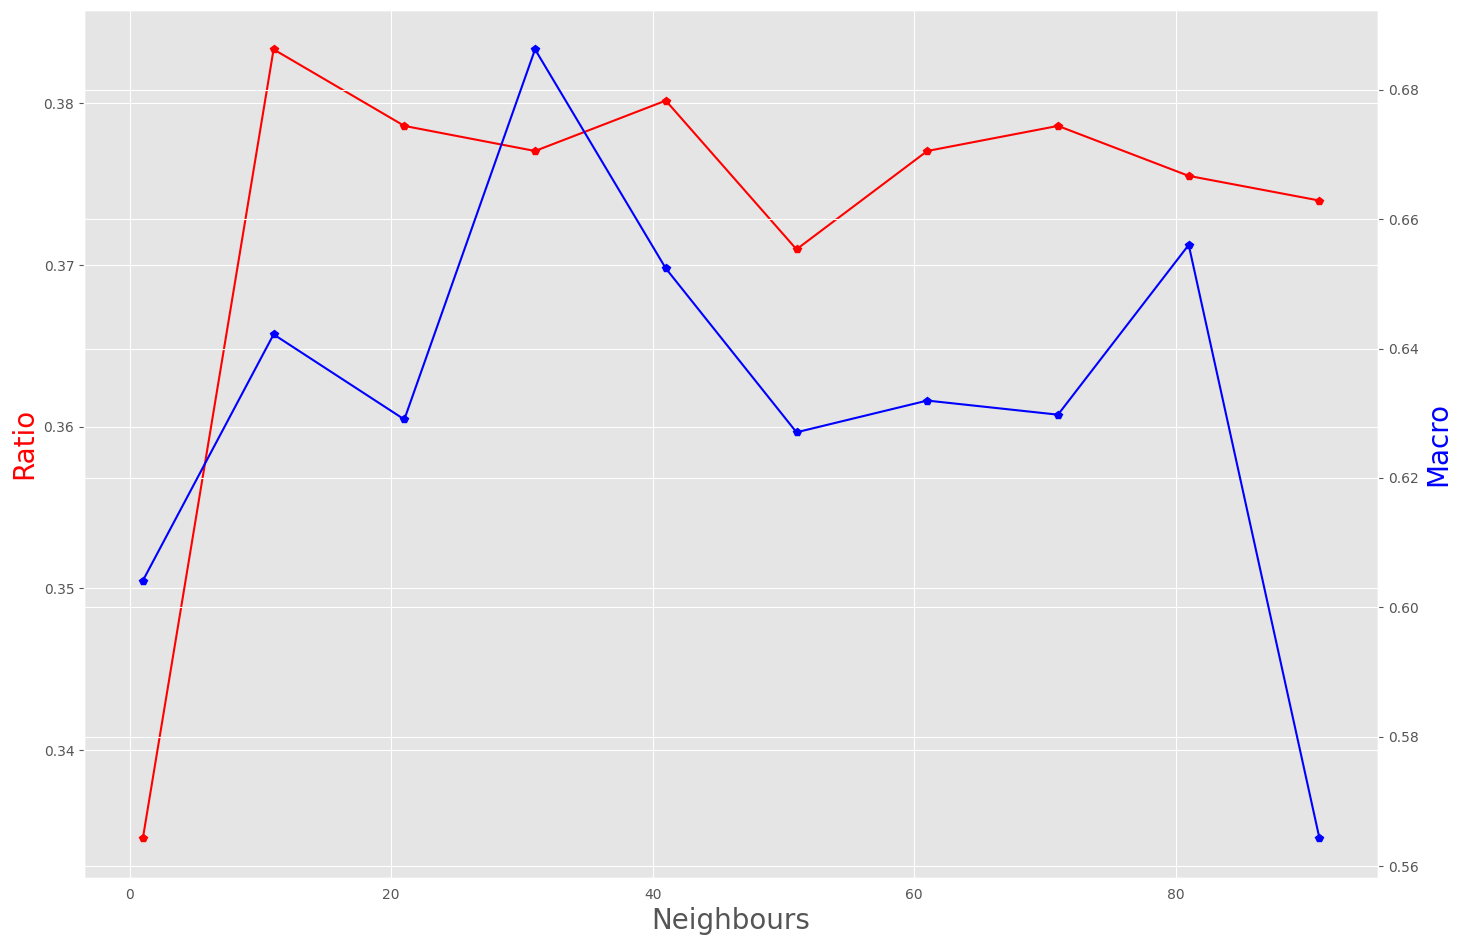

<Figure size 600x400 with 0 Axes>

In [ ]:
fig,ax = plt.subplots()
# make a plot
ax.plot(neigh, imb,
        color="red",
        marker="p")
# set x-axis label
ax.set_xlabel('Neighbours', fontsize = 20)
# set y-axis label
ax.set_ylabel('Ratio',
              color="red",
              fontsize=20)

# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(neigh, macros,color="blue",marker="p")
ax2.set_ylabel('Macro',color="blue",fontsize=20)
plt.figure(figsize=(6,4))
plt.show() #carino ma speravo fosse più capibile

## cnn is not able to modify the ratio a lot

#### Undersampling 3 - Tomek

In [ ]:
tl = TomekLinks()
X_tl_reb, y_tl_reb = tl.fit_resample(df_final_train, emotion_train_bin)
print('Resampled dataset shape %s' % Counter(y_tl_reb))

Resampled dataset shape Counter({0: 1132, 1: 92})


In [ ]:
grid = RandomizedSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_distributions=param_grid,
    cv=RepeatedStratifiedKFold(random_state=42),
    n_jobs=-1,
    n_iter=100,
)
grid.fit(X_tl_reb, y_tl_reb)
clf_tom = grid.best_estimator_
print(grid.best_params_, grid.best_score_)

{'criterion': 'gini', 'max_depth': 32, 'min_samples_leaf': 0.16061257341295695, 'min_samples_split': 0.1956826359848237} 0.9248377383740382


In [ ]:
#clf.fit(X_tl_reb, y_tl_reb)

y_pred_tl_reb = clf_tom.predict(df_final_test)

print('Accuracy %s' % accuracy_score(emotion_test_bin, y_pred_tl_reb))
print('F1-score %s' % f1_score(emotion_test_bin, y_pred_tl_reb, average=None))
print(classification_report(emotion_test_bin, y_pred_tl_reb))

Accuracy 0.9168207024029574
F1-score [0.95660559 0.        ]
              precision    recall  f1-score   support

           0       0.92      1.00      0.96       496
           1       0.00      0.00      0.00        45

    accuracy                           0.92       541
   macro avg       0.46      0.50      0.48       541
weighted avg       0.84      0.92      0.88       541



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Undersampling 4 - EditedKnn

In [ ]:
enn = EditedNearestNeighbours(n_neighbors=300)
X_enn_reb, y_enn_reb = enn.fit_resample(df_final_train_norm, emotion_train_bin)
print('Resampled dataset shape %s' % Counter(y_enn_reb))

Resampled dataset shape Counter({0: 121, 1: 87})


In [ ]:
grid = RandomizedSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_distributions=param_grid,
    cv=RepeatedStratifiedKFold(random_state=42),
    n_jobs=-1,
    n_iter=100,
)
grid.fit(X_enn_reb, y_enn_reb)
clf_enn = grid.best_estimator_
print(grid.best_params_, grid.best_score_)

{'criterion': 'entropy', 'max_depth': 65, 'min_samples_leaf': 0.13981978009710555, 'min_samples_split': 0.02854253221371205} 0.9867852062588905


In [ ]:
#clf.fit(X_enn_reb, y_enn_reb)

y_pred_enn_reb = clf_enn.predict(df_final_test_norm)

print('Accuracy %s' % accuracy_score(emotion_test_bin, y_pred_enn_reb))
print('F1-score %s' % f1_score(emotion_test_bin, y_pred_enn_reb, average=None))
print(classification_report(emotion_test_bin, y_pred_enn_reb))

Accuracy 0.5268022181146026
F1-score [0.65217391 0.26011561]
              precision    recall  f1-score   support

           0       1.00      0.48      0.65       496
           1       0.15      1.00      0.26        45

    accuracy                           0.53       541
   macro avg       0.57      0.74      0.46       541
weighted avg       0.93      0.53      0.62       541



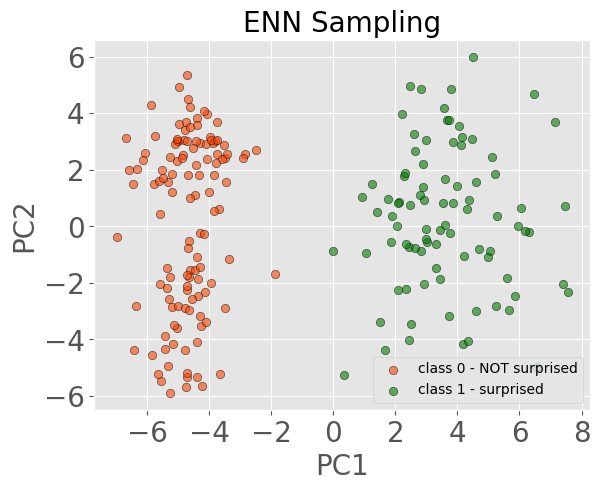

<Figure size 600x400 with 0 Axes>

In [ ]:
pca_enn = PCA(n_components=2)
pca_enn.fit(df_final_train_norm)
X_pca_enn = pca.transform(X_enn_reb)
fig,ax = plt.subplots()

plt.scatter(X_pca_enn[y_enn_reb==0,0], X_pca_enn[y_enn_reb==0, 1], c='orangered', edgecolor='k', alpha=0.6, label='class 0 - NOT surprised')
plt.scatter(X_pca_enn[y_enn_reb==1,0], X_pca_enn[y_enn_reb==1, 1], c='green', edgecolor='k', alpha=0.6, label='class 1 - surprised')

ax.set_xlabel('PC1', fontsize=20)
ax.set_ylabel('PC2', fontsize=20)
ax.set_title('ENN Sampling', fontsize=20)
ax.legend()
plt.xticks(size=20)
plt.yticks(size=20)
plt.figure(figsize=(6,4))
plt.show()

In [ ]:
imb=[]
neigh=[n for n in range (1,500,20)]

macros=[]

for n in neigh:
    enn = EditedNearestNeighbours(n_neighbors=n)
    X_enn_reb, y_enn_reb = enn.fit_resample(df_final_train_norm, emotion_train_bin)
    x=Counter(y_enn_reb)
    imb.append(x[1]/(x[0]+x[1]))
    clf_enn.fit(X_enn_reb,y_enn_reb)
    y_pred_enn_reb = clf_enn.predict(df_final_test_norm)
    macro=f1_score(emotion_test_bin, y_pred_enn_reb, average='macro')
    macros.append(macro)

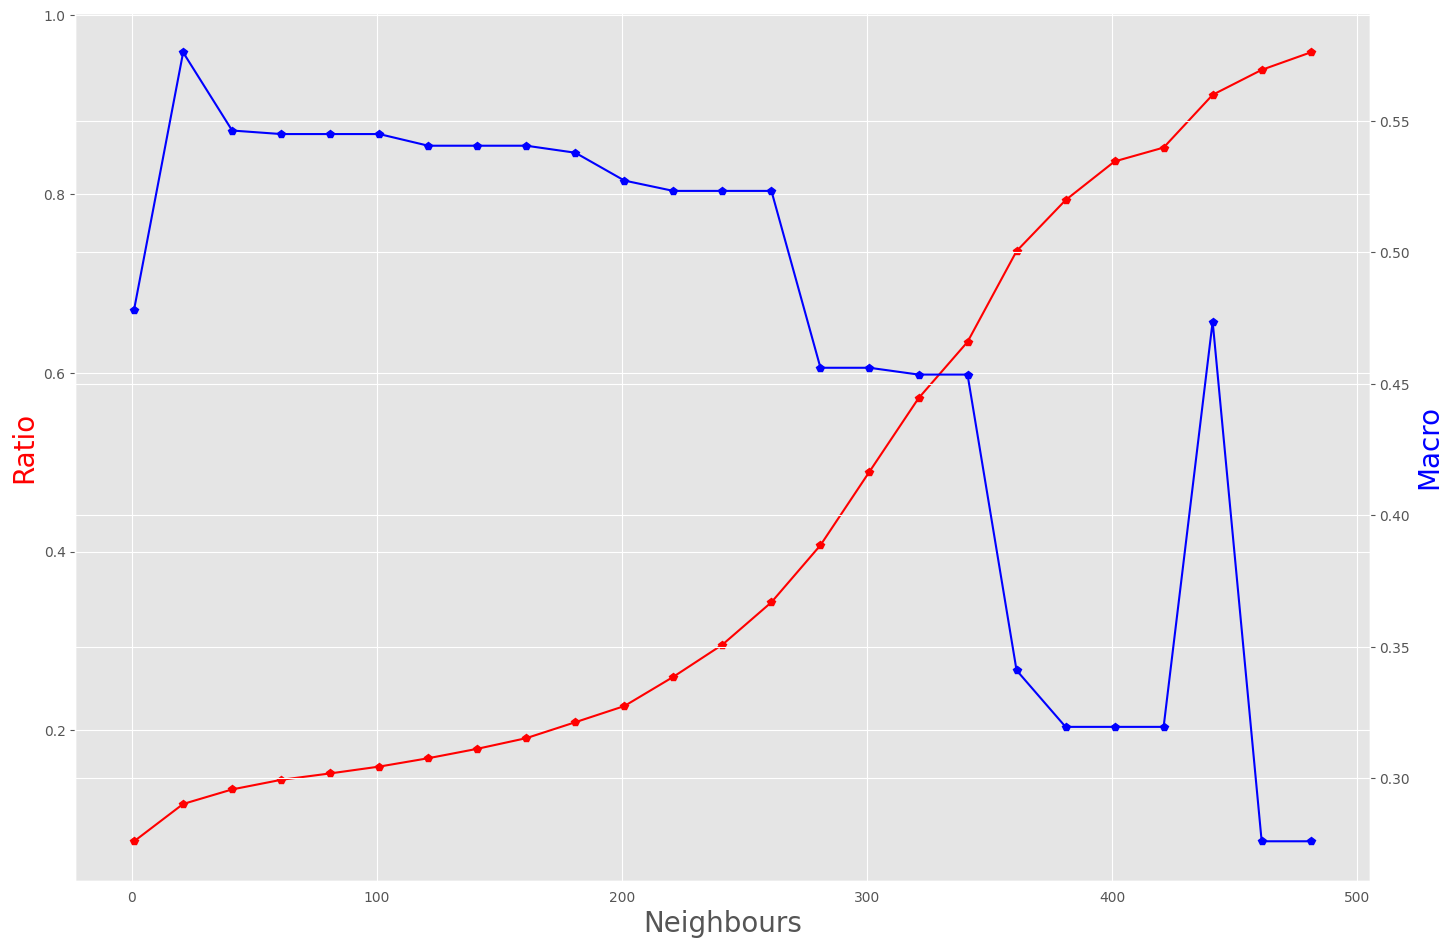

<Figure size 600x400 with 0 Axes>

In [ ]:
fig,ax = plt.subplots()
# make a plot
ax.plot(neigh, imb,
        color="red",
        marker="p")
# set x-axis label
ax.set_xlabel('Neighbours', fontsize = 20)
# set y-axis label
ax.set_ylabel('Ratio',
              color="red",
              fontsize=20)

# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(neigh, macros,color="blue",marker="p")
ax2.set_ylabel('Macro',color="blue",fontsize=20)
plt.figure(figsize=(6,4))

plt.show()

### COMBINING OVERSAMPLING AND UNDERSAMPLING

Combining oversampling and undersampling techniques:
it can be done both manually and automatically.
* if manually: first perform SMOTE,RandomUnderSampler. Again, the order in which these procedures are applied does not matter as they are performed on different subsets of the training dataset.

The pipeline below implements this combination, first applying SMOTE to bring the minority class distribution to 10 percent of the majority class, then using RandomUnderSampler to bring the majority class down to 50 percent more than the minority class before fitting a DecisionTreeClassifier.

* if automatically: SMOTETomek class, where first the SMOTE method is applied to oversample the minority class to a balanced distribution, then examples in Tomek Links from the majority classes are identified and removed.

In [ ]:
from imblearn.combine import SMOTETomek, SMOTEENN
from imblearn.under_sampling import TomekLinks
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

In [ ]:
# Oversampling using SMOTE and cleaning using Tomek link
smotetomek = SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'))
X_res_combo_1, y_res_combo_1 = smotetomek.fit_resample(df_final_train_norm, emotion_train_bin)
# print('Resampled dataset shape %s' % Counter(y_res_combo_1))

# valuto efficacia della combo smote + tomek
param_grid = {
    "min_samples_split": loguniform(1e-2, 1e0),
    "min_samples_leaf": uniform(0.001, 0.2),
    "max_depth": randint(2, 200),
    "criterion": ["gini", "entropy"],
}
grid = RandomizedSearchCV(
    DecisionTreeClassifier(),
    param_distributions=param_grid,
    cv=RepeatedStratifiedKFold(),
    n_jobs=-1,
    n_iter=10,
)
grid.fit(X_res_combo_1, y_res_combo_1)
clf_combo_1 = grid.best_estimator_
print(grid.best_params_, grid.best_score_)

y_pred_combo_1 = clf_combo_1.predict(df_final_test_norm)

print('Accuracy %s' % accuracy_score(emotion_test_bin, y_pred_combo_1))
print(classification_report(emotion_test_bin, y_pred_combo_1))

{'criterion': 'entropy', 'max_depth': 107, 'min_samples_leaf': 0.03777355920292141, 'min_samples_split': 0.07947365461312539} 0.8529870707254004
Accuracy 0.8148148148148148
              precision    recall  f1-score   support

           0       0.96      0.83      0.89       488
           1       0.30      0.67      0.41        52

    accuracy                           0.81       540
   macro avg       0.63      0.75      0.65       540
weighted avg       0.90      0.81      0.84       540



In [ ]:
# Oversampling using SMOTE and undersampling with Edited nearest Neighbours
smoteENN = SMOTEENN()

X_res_combo, y_res_combo = smoteENN.fit_resample(df_final_train_norm, emotion_train_bin)
print('Resampled dataset shape %s' % Counter(y_res_combo))

Resampled dataset shape Counter({1: 1171, 0: 896})


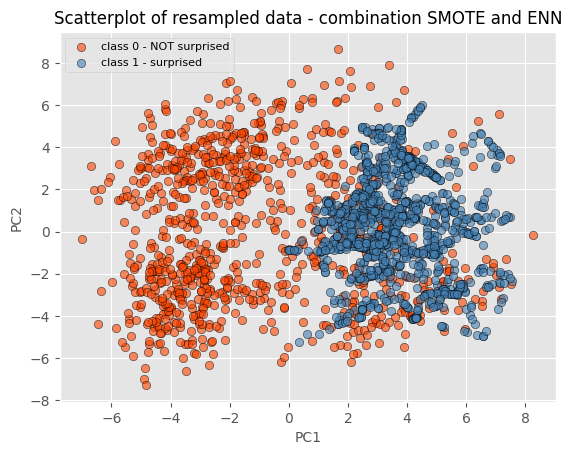

In [ ]:
#PCA smoteENN
pca_combo = PCA(n_components=2)
pca_combo.fit(df_final_norm)
X_pca_combo = pca.transform(X_res_combo)

# scatterplot per ogni classe
plt.scatter(X_pca_combo[y_res_combo==0, 0], X_pca_combo[y_res_combo==0, 1], c='orangered', edgecolor='k', alpha=0.6, label='class 0 - NOT surprised')
plt.scatter(X_pca_combo[y_res_combo==1, 0], X_pca_combo[y_res_combo==1, 1], c='steelblue', edgecolor='k', alpha=0.6, label='class 1 - surprised')


# Create automatic legend based on labels specified in scatter() function
plt.legend(loc='upper left', fontsize = 8)
plt.title('Scatterplot of resampled data - combination SMOTE and ENN', fontsize= 12)
plt.xlabel('PC1', fontsize = 10)
plt.ylabel('PC2', fontsize = 10)
plt.style.use('ggplot')
plt.show()


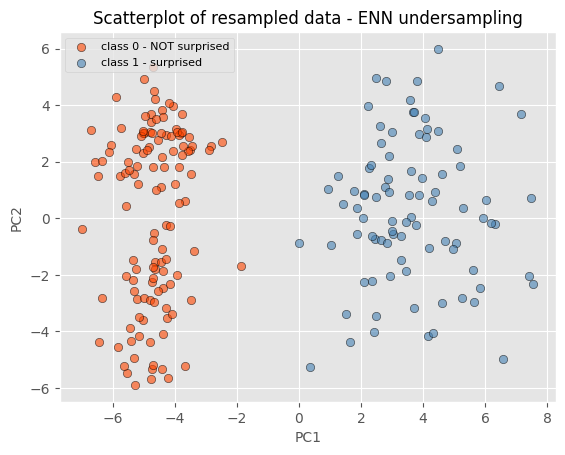

In [ ]:
pca_enn = PCA(n_components=2)
pca_enn.fit(df_final_train_norm)
X_pca_enn = pca.transform(X_enn_reb)
fig,ax = plt.subplots()

plt.scatter(X_pca_enn[y_enn_reb==0,0], X_pca_enn[y_enn_reb==0, 1], c='orangered', edgecolor='k', alpha=0.6, label='class 0 - NOT surprised')
plt.scatter(X_pca_enn[y_enn_reb==1,0], X_pca_enn[y_enn_reb==1, 1], c='steelblue', edgecolor='k', alpha=0.6, label='class 1 - surprised')

# Create automatic legend based on labels specified in scatter() function
plt.legend(loc='upper left', fontsize = 8)
plt.title('Scatterplot of resampled data - ENN undersampling', fontsize= 12)
plt.xlabel('PC1', fontsize = 10)
plt.ylabel('PC2', fontsize = 10)
plt.style.use('ggplot')
plt.show()

In [ ]:
# valuto efficacia della combo smote enn
param_grid = {
    "min_samples_split": loguniform(1e-2, 1e0),
    "min_samples_leaf": uniform(0.001, 0.2),
    "max_depth": randint(2, 200),
    "criterion": ["gini", "entropy"],
}
grid = RandomizedSearchCV(
    DecisionTreeClassifier(),
    param_distributions=param_grid,
    cv=RepeatedStratifiedKFold(),
    n_jobs=-1,
    n_iter=10,
)
grid.fit(X_res_combo, y_res_combo)
clf_combo = grid.best_estimator_
print(grid.best_params_, grid.best_score_)

{'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 0.012547255930196212, 'min_samples_split': 0.055346987819919695} 0.9047941888619855


In [ ]:
y_pred_combo = clf_combo.predict(df_final_test_norm)

print('Accuracy %s' % accuracy_score(emotion_test_bin, y_pred_combo))
print('F1-score %s' % f1_score(emotion_test_bin, y_pred_combo, average=None))
print(classification_report(emotion_test_bin, y_pred_combo))

Accuracy 0.8059149722735675
F1-score [0.88346282 0.4198895 ]
              precision    recall  f1-score   support

           0       0.98      0.80      0.88       496
           1       0.28      0.84      0.42        45

    accuracy                           0.81       541
   macro avg       0.63      0.82      0.65       541
weighted avg       0.92      0.81      0.84       541



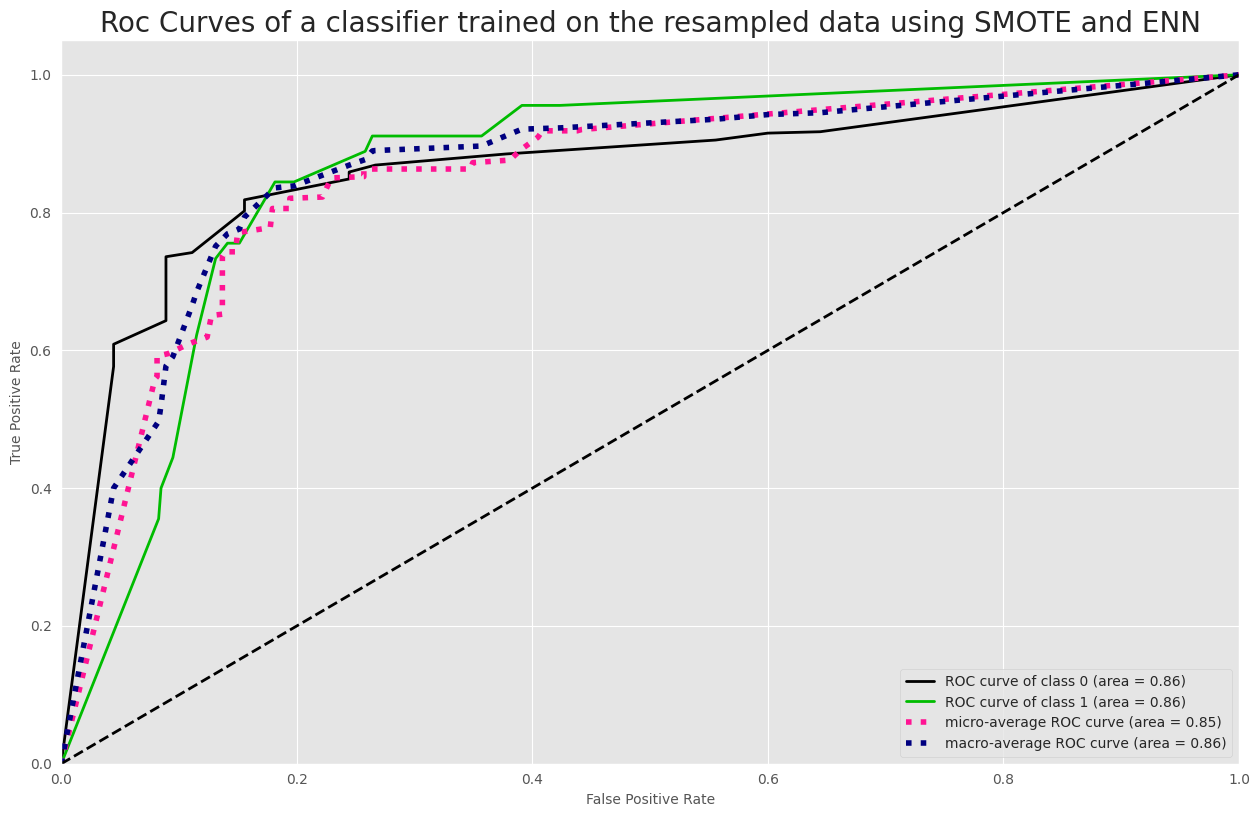

In [ ]:
y_score_combo = clf_combo.predict_proba(df_final_test_norm)
plot_roc(emotion_test_bin, y_score_combo)
plt.title("Roc Curves of a classifier trained on the resampled data using SMOTE and ENN", fontsize=20)
plt.tight_layout()
plt.show()